In [1]:
# Import Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix

import re
import argparse
import os

from IPython.display import display

from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill
from datetime import datetime

from statsmodels.tsa.seasonal import MSTL

from xgboost import XGBRegressor
from xgboost import XGBClassifier
import joblib

In [2]:
# Prepare Train Data for Preprocessing
df_check = pd.read_excel('check_data_to_students.xlsx')
df_train = pd.read_excel("train_data.xlsx")
df_validation = pd.read_excel("validation_data.xlsx")

df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.set_index('Date', inplace=True)

power_columns = [f"Power{i}" for i in range(1, 97)]    # Define the list of power columns (assumes columns are named "Power1", "Power2", ..., "Power96")

In [3]:
# Helper Plotting Functions

# Function to Plot Data Over Daily Period
def plot_daily_load_data(df, day_date, power_columns, freq='15min', 
                        marker_size=2, color='blue', figsize=(15, 5)):
    # Input validation
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")
    
    try:
        day_date = pd.to_datetime(day_date)
        next_day = day_date + pd.Timedelta(days=1)
    except:
        raise ValueError("day_date must be in 'YYYY-MM-DD' format")
    
    # Filter data for the day
    try:
        df_day = df.loc[day_date:next_day].copy()
        if len(df_day) == 0:
            raise ValueError("No data found for the specified day")
    except Exception as e:
        available_dates = f"{df.index[0].date()} to {df.index[-1].date()}"
        raise ValueError(f"Date not available. Data exists from {available_dates}") from e
    
    # Process data
    flattened_data = df_day[power_columns].values.flatten()
    time_axis = pd.date_range(
        start=df_day.index[0], 
        periods=len(flattened_data), 
        freq=freq
    )
    
    # Plotting
    plt.figure(figsize=figsize)
    plt.plot(
        time_axis, 
        flattened_data, 
        marker='o', 
        linestyle='-', 
        markersize=marker_size, 
        color=color,
        alpha=0.7
    )
    
    # Formatting
    plt.title(f'Daily Load Data for {day_date.date()}')
    plt.xlabel('Time of Day')
    plt.ylabel('Load (kW)')
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    
    # Add time period shading
    ax = plt.gca()
    
    # Morning (6AM-9AM)
    ax.axvspan(
        day_date.replace(hour=6), 
        day_date.replace(hour=9), 
        color='green', 
        alpha=0.05,
        label='Morning'
    )
    
    # Evening (6PM-9PM)
    ax.axvspan(
        day_date.replace(hour=18), 
        day_date.replace(hour=21), 
        color='orange', 
        alpha=0.05,
        label='Evening'
    )
    
    # Night (10PM-5AM)
    ax.axvspan(
        day_date.replace(hour=22), 
        day_date.replace(hour=5), 
        color='gray', 
        alpha=0.1,
        label='Night'
    )
    
    # Add hour markers
    for hour in range(0, 24):
        ax.axvline(
            day_date.replace(hour=hour),
            color='red' if hour in [0, 12, 18] else 'yellow',
            alpha=0.1,
            linestyle='--',
            linewidth=1
        )
    
    # Format x-axis to show hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return df_day

# Function to Plot Data Over Weekly Period
def plot_weekly_load_data(df, start_date, power_columns, freq='15min', 
                         marker_size=2, color='blue', figsize=(15, 5)):
    # Input validation
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")
    
    try:
        start_date = pd.to_datetime(start_date)
        end_date = start_date + pd.Timedelta(days=7)
    except:
        raise ValueError("start_date must be in 'YYYY-MM-DD' format")
    
    # Filter data for the week
    try:
        df_week = df.loc[start_date:end_date].copy()
        if len(df_week) == 0:
            raise ValueError("No data found for the specified week")
    except Exception as e:
        available_dates = f"{df.index[0].date()} to {df.index[-1].date()}"
        raise ValueError(f"Date range not available. Data exists from {available_dates}") from e
    
    # Process data
    flattened_data = df_week[power_columns].values.flatten()
    time_axis = pd.date_range(
        start=df_week.index[0], 
        periods=len(flattened_data), 
        freq=freq
    )
    
    # Plotting
    plt.figure(figsize=figsize)
    plt.plot(
        time_axis, 
        flattened_data, 
        marker='o', 
        linestyle='-', 
        markersize=marker_size, 
        color=color,
        alpha=0.7
    )
    
    # Formatting
    plt.title(f'Weekly Load Data from {start_date.date()} to {end_date.date()}')
    plt.xlabel('Time')
    plt.ylabel('Load (kW)')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    
    # Add shaded nights and day markers
    ax = plt.gca()
    for day in pd.date_range(start_date, periods=7, freq='D'):
        # Night shading (10PM-6AM)
        ax.axvspan(
            day.replace(hour=22), 
            (day + pd.Timedelta(days=1)).replace(hour=6), 
            color='gray', 
            alpha=0.1
        )
        # Noon marker
        ax.axvline(
            day.replace(hour=12),
            color='yellow',
            alpha=0.2,
            linestyle='--',
            linewidth=1
        )
    
    # Format x-axis to show days clearly
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%H:%M'))
    plt.tight_layout()
    plt.show()
    
    return df_week

# Function to Plot Data Over Monthly Period
def plot_monthly_load_data(df, month_str, power_columns, freq='15min', 
                          marker_size=2, color='blue', figsize=(15, 5)):
    # Input validation
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")
    
    if month_str not in df.index.strftime('%Y-%m').unique():
        available_months = df.index.strftime('%Y-%m').unique()
        raise ValueError(f"Month not found. Available months: {available_months}")
    
    # Filter and process data
    try:
        df_month = df.loc[month_str].sort_index()
        flattened_data = df_month[power_columns].values.flatten()
        
        # Generate time axis
        start_date = df_month.index[0]
        time_axis = pd.date_range(
            start=start_date, 
            periods=len(flattened_data), 
            freq=freq
        )
        
        # Plotting
        plt.figure(figsize=figsize)
        plt.plot(
            time_axis, 
            flattened_data, 
            marker='o', 
            linestyle='-', 
            markersize=marker_size, 
            color=color,
            alpha=0.7
        )
        
        # Formatting
        plt.title(f'Continuous {freq} Load Data for {month_str}')
        plt.xlabel('Time')
        plt.ylabel('Load (kW)')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        
        # Add shaded nights
        if isinstance(time_axis[0], pd.Timestamp):
            ax = plt.gca()
            for day in pd.date_range(start_date, periods=31, freq='D'):
                if day.month == start_date.month:  # Only shade for selected month
                    ax.axvspan(
                        day.replace(hour=0), 
                        day.replace(hour=6), 
                        color='gray', 
                        alpha=0.1
                    )
        
        plt.tight_layout()
        plt.show()
        
        return df_month
    
    except Exception as e:
        print(f"Error processing data: {str(e)}")
        return None

# Function to Plot Data Over Seasonal Period
def plot_seasonal_load_data(df, season_year, season_name, power_columns, freq='15min', 
                           compare_years=False, year_range=None, figsize=(18, 8)):
    # Validate season input
    valid_seasons = ['winter', 'spring', 'summer', 'autumn']
    if season_name.lower() not in valid_seasons:
        raise ValueError(f"Invalid season. Must be one of: {valid_seasons}")
    
    # Define seasonal date ranges
    season_ranges = {
        'winter': ('12-21', '03-20'),  # Dec 21 - Mar 20
        'spring': ('03-21', '06-20'),  # Mar 21 - Jun 20
        'summer': ('06-21', '09-20'),  # Jun 21 - Sep 20
        'autumn': ('09-21', '12-20')  # Sep 21 - Dec 20
    }
    
    # Prepare plot
    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    seasonal_data = {}
    
    # Determine years to analyze
    years_to_compare = [season_year]
    if compare_years and year_range:
        years_to_compare.extend(range(year_range[0], year_range[1]))
        years_to_compare = sorted(list(set(years_to_compare)))  # Remove duplicates
    
    for year in years_to_compare:
        # Construct date range
        start_date = pd.to_datetime(f"{year}-{season_ranges[season_name][0]}")
        end_date = pd.to_datetime(f"{year}-{season_ranges[season_name][1]}")
        
        # Handle winter spanning year change
        if season_name == 'winter':
            end_date = pd.to_datetime(f"{year+1}-{season_ranges[season_name][1]}")
        
        # Filter data
        df_season = df.loc[start_date:end_date].copy()
        
        if len(df_season) == 0:
            print(f"No data found for {season_name} {year}")
            continue
        
        # Resample to daily averages for cleaner visualization
        df_daily = df_season[power_columns].resample('D').mean()
        
        # Plot seasonal trend
        for col in power_columns:
            label = f"{year} {col}" if compare_years else col
            ax.plot(df_daily.index, df_daily[col], 
                    label=label,
                    alpha=0.8 if compare_years else 1,
                    linewidth=2 if year == season_year else 1.5)
        
        seasonal_data[year] = df_season
    
    # Formatting
    plt.title(f"{season_name.capitalize()} Load Patterns ({season_year}" + 
              (f" vs {year_range[0]}-{year_range[1]-1}" if compare_years else "") + ")")
    plt.xlabel('Date')
    plt.ylabel('Average Daily Load (kW)')
    
    # Add seasonal markers
    if season_name == 'summer':
        ax.axvspan(pd.to_datetime(f"{season_year}-07-01"), 
                  pd.to_datetime(f"{season_year}-08-31"), 
                  color='yellow', alpha=0.05, label='Peak Summer')
    elif season_name == 'winter':
        ax.axvspan(pd.to_datetime(f"{season_year}-12-25"), 
                  pd.to_datetime(f"{season_year+1 if season_name=='winter' else season_year}-01-05"), 
                  color='blue', alpha=0.05, label='Holiday Period')
    
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return seasonal_data if compare_years else df_season

In [4]:
# Data Preprocessing Helper Functions
def find_missing_sequences(missing_bool):
    sequences = []
    start = None
    
    for i, val in enumerate(missing_bool):
        if val and start is None:
            start = i
        elif not val and start is not None:
            sequences.append((start, i-1))
            start = None
    
    if start is not None:
        sequences.append((start, len(missing_bool)-1))
    
    return sequences

def normalize_row(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    # Avoid division by zero if all values are identical.
    if max_val - min_val == 0:
        return arr
    return (arr - min_val) / (max_val - min_val)
    
def impute_row(row, power_columns):
    arr = row[power_columns].values.copy()
    missing_bool = pd.isnull(arr)
    sequences = find_missing_sequences(missing_bool)
    
    for start, end in sequences:
        seq_len = end - start + 1
        
        # Single missing value
        if seq_len == 1:
            if start > 0:
                arr[start] = arr[start-1]  # forward fill
            else:
                arr[start] = arr[end+1] if end+1 < len(arr) else np.nan
        
        # Small gaps (2-4 missing)
        elif 2 <= seq_len <= 4:
            left_idx = max(0, start-1)
            right_idx = min(len(arr)-1, end+1)
            left_val = arr[left_idx]
            right_val = arr[right_idx]
            
            # Linear interpolation
            for i in range(seq_len):
                arr[start+i] = left_val + (right_val-left_val)*(i+1)/(seq_len+1)
        
        # Larger gaps (5-38 missing)
        else:
            left_idx = max(0, start-1)
            right_idx = min(len(arr)-1, end+1)
            left_val = arr[left_idx]
            right_val = arr[right_idx]
            
            # Linear interpolation for larger gaps
            for i in range(seq_len):
                arr[start+i] = left_val + (right_val-left_val)*(i+1)/(seq_len+1)
    
    return arr

def time_series_impute(df, method='linear', max_total_threshold=38, power_columns=power_columns):
    df_imputed = df.copy()
    
    # Convert index to datetime if needed
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'timestamp' in df.columns:
            df_imputed = df_imputed.set_index('timestamp')
        elif 'date' in df.columns:
            df_imputed = df_imputed.set_index('date')
        df_imputed.index = pd.to_datetime(df_imputed.index)
    
    # Sort by time
    df_imputed = df_imputed.sort_index()
    
    # Apply selected imputation method to remaining missing values
    if method == 'linear':
        df_imputed = df_imputed.interpolate(method='linear')
    elif method == 'ffill':
        df_imputed = df_imputed.ffill()
    elif method == 'spline':
        df_imputed = df_imputed.interpolate(method='spline', order=3)
    elif method == 'seasonal':
        if df_imputed.index.hour.nunique() > 1:
            df_imputed = df_imputed.groupby(df_imputed.index.hour).transform(
                lambda x: x.interpolate(method='linear'))
        else:
            df_imputed = df_imputed.interpolate(method='linear')
    
    # Final processing statistics
    remaining_missing = df_imputed.isnull().sum().sum()
    if remaining_missing > 0:
        print(f"Note: {remaining_missing} missing values remain after processing")
    
    return df_imputed

In [5]:
# Determine Quantity and Location of Missing Values
processed_rows = []
invalid_days_info = {}

# Process each day (row) in the dataset to populate invalid_days_info
for day, row in df_train.iterrows():
    # Extract the 96 power measurements as a NumPy array
    arr = row[power_columns].values
    # Create a boolean array indicating where values are missing
    missing_bool = pd.isnull(arr)
    # Identify consecutive missing sequences
    sequences = find_missing_sequences(missing_bool)
    # Total missing count for the day
    total_missing = int(missing_bool.sum())
    # Store lengths of each missing sequence
    sequences_lengths = [end - start + 1 for (start, end) in sequences] if sequences else []
    
    # If there are any missing values, store the information
    if total_missing > 0:
        invalid_days_info[day] = {
            'total_missing': total_missing,
            'sequences': sequences_lengths,
            'missing_positions': np.where(missing_bool)[0].tolist()  # Adding positions of missing values
        }
    else:
        # If no missing values, add the row to processed rows as-is
        processed_rows.append(row.copy())

# Print details of invalid days.
if invalid_days_info:
    print("Invalid days with missing measurements:")
    for day, info in invalid_days_info.items():
        date_str = day.strftime('%Y-%m-%d')
        total = info['total_missing']
        seqs_str = ", ".join(str(length) for length in info['sequences'])
        print(f"{date_str}: Total missing: {total}, Consecutive sequences: [{seqs_str}]")
else:
    print("No invalid days found.")

Invalid days with missing measurements:
2022-01-02: Total missing: 63, Consecutive sequences: [63]
2022-02-05: Total missing: 8, Consecutive sequences: [8]
2022-04-07: Total missing: 8, Consecutive sequences: [1, 1, 3, 1, 2]
2022-04-08: Total missing: 1, Consecutive sequences: [1]
2022-04-09: Total missing: 28, Consecutive sequences: [28]
2022-04-11: Total missing: 58, Consecutive sequences: [58]
2022-04-13: Total missing: 1, Consecutive sequences: [1]
2022-04-20: Total missing: 1, Consecutive sequences: [1]
2022-04-21: Total missing: 1, Consecutive sequences: [1]
2022-04-22: Total missing: 48, Consecutive sequences: [2, 46]
2022-05-05: Total missing: 23, Consecutive sequences: [3, 9, 2, 1, 1, 1, 6]
2022-05-12: Total missing: 2, Consecutive sequences: [2]
2022-05-16: Total missing: 1, Consecutive sequences: [1]
2022-06-01: Total missing: 1, Consecutive sequences: [1]
2022-06-07: Total missing: 4, Consecutive sequences: [4]
2022-06-08: Total missing: 1, Consecutive sequences: [1]
2022-0

In [6]:
# First Pass to Handle Missing Values
removed_info = {}
processed_rows = []
threshold = 38

for idx, row in df_train.iterrows():
    missing_count = row[power_columns].isnull().sum()
    
    # Strict removal condition
    if missing_count > threshold:
        removed_info[idx] = {
            'missing_count': missing_count,
            'missing_positions': np.where(row[power_columns].isnull())[0].tolist(),
            'original_data': row[power_columns].values.tolist()
        }
        continue  # Skip this row entirely
    
    # Only process rows that meet the threshold
    if missing_count > 0:
        imputed_values = impute_row(row, power_columns)
        row[power_columns] = imputed_values
    
    processed_rows.append(row)

# Create the processed DataFrame
processed_df = pd.DataFrame(processed_rows)

# Print summary
print(f"Total missing values remaining: {processed_df[power_columns].isnull().sum().sum()}")

processed_df.index = processed_df.index.strftime('%Y-%m-%d')

# Save the preprocessed valid data to a new Excel file.
output_filename = 'preprocessed_data_1.xlsx'
processed_df.to_excel(output_filename, index_label='Date')

print(f"Preprocessed data written to {output_filename}")

Total missing values remaining: 90
Preprocessed data written to preprocessed_data_1.xlsx


In [7]:
# Second Pass to Handle Missing Values
df_train_2 = pd.read_excel("preprocessed_data_1.xlsx")

# Set the date column as index
df_train_2 = df_train_2.set_index('Date')
df_train_2.index = pd.to_datetime(df_train_2.index)

# Can use different method to adjust how the missing values are filled
processed_df_2 = time_series_impute(df=df_train_2, method='linear', max_total_threshold=38, power_columns=power_columns)

# Print summary
print(f"Total missing values remaining: {processed_df_2[power_columns].isnull().sum().sum()}")

processed_df_2.index = processed_df_2.index.strftime('%Y-%m-%d')

# Save the preprocessed valid data to a new Excel file.
output_filename_2 = 'preprocessed_data_2.xlsx'
processed_df_2.to_excel(output_filename_2, index_label='Date')

print(f"Preprocessed data written to {output_filename_2}")

Total missing values remaining: 0
Preprocessed data written to preprocessed_data_2.xlsx


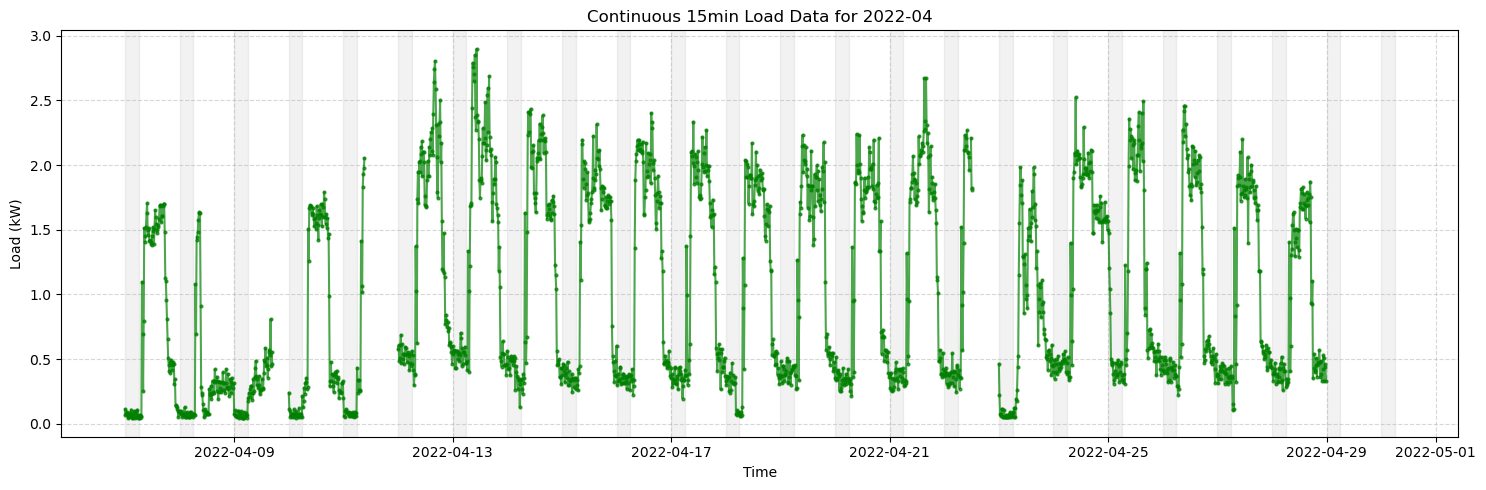

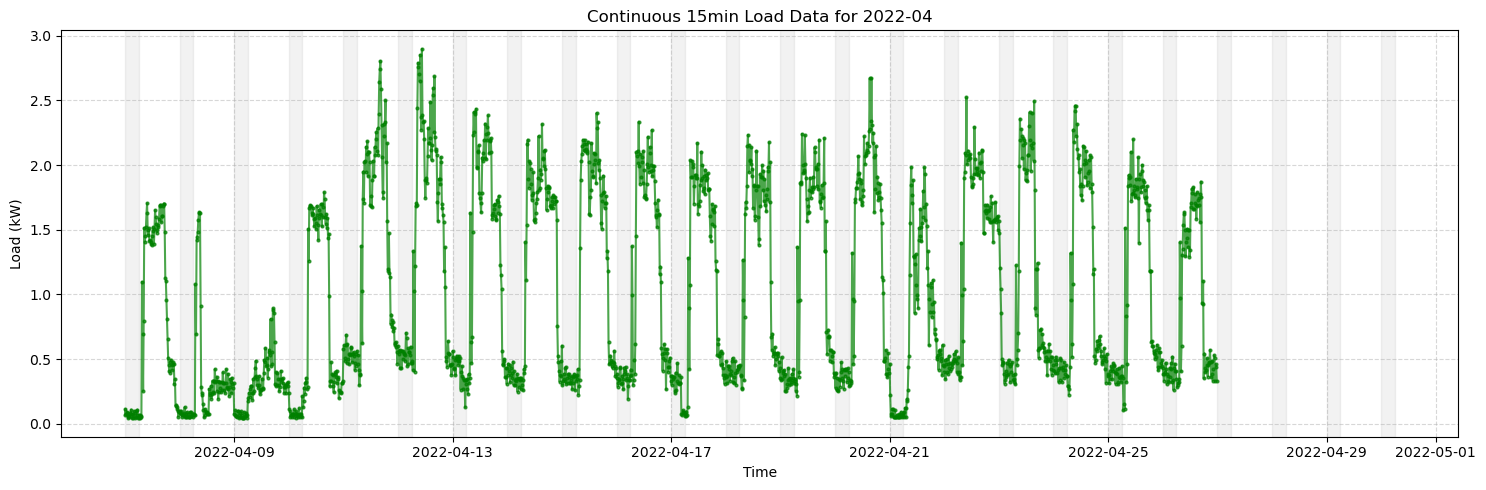

In [8]:
# Before and After Data Changes
df_train_clean = pd.read_excel('preprocessed_data_2.xlsx')

df_train_clean['Date'] = pd.to_datetime(df_train_clean['Date'])
df_train_clean.set_index('Date', inplace=True)

selected_month = '2022-04'                             # Change this string to a different month if needed.
df_month = df_train_clean.loc[selected_month]
df_month = df_month.sort_index()                       # Ensure the data for the selected month is sorted by date.

monthly = plot_monthly_load_data(df=df_train, month_str=selected_month, power_columns=power_columns, freq='15min', color='green')
imputed = plot_monthly_load_data(df=df_month, month_str=selected_month, power_columns=power_columns, freq='15min', color='green')

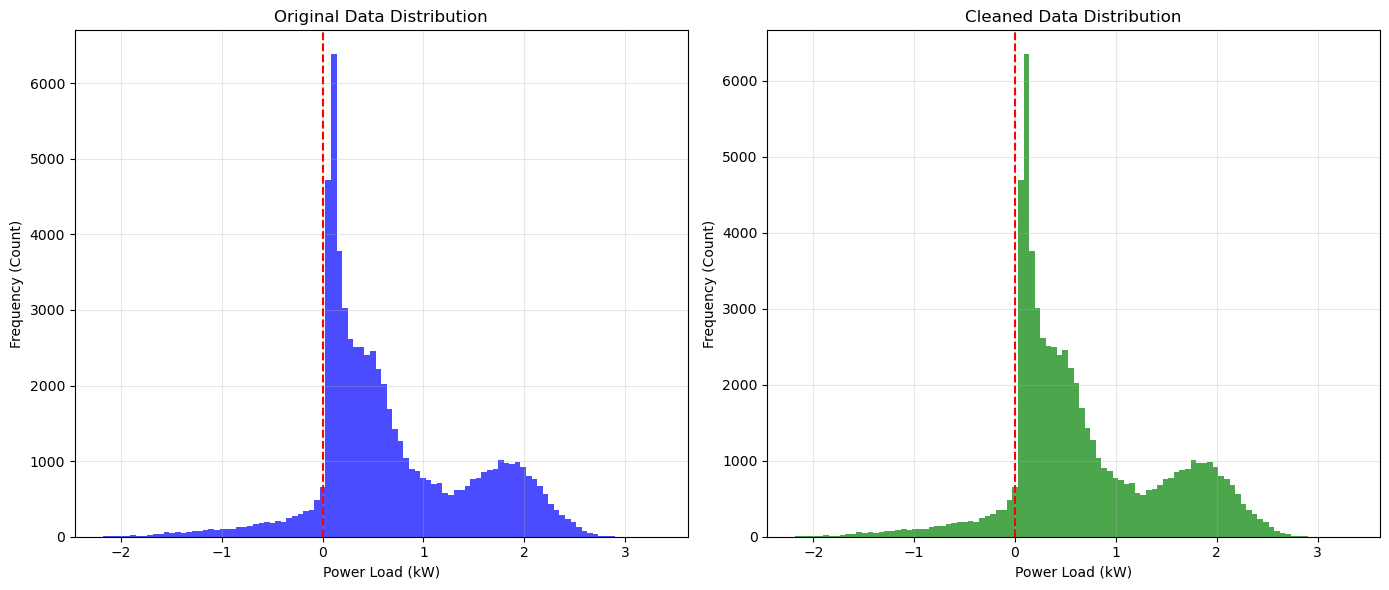

In [9]:
# Normalize/scale if using models sensitive to magnitude
scaler = MinMaxScaler()
df_train_2[df_train_2.columns] = scaler.fit_transform(df_train_2[df_train_2.columns])

# Visualize distribution
# Create figure with subplots
plt.figure(figsize=(14, 6))

# Original Data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.hist(df_train[power_columns].values.flatten(), bins=100, color='blue', alpha=0.7)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Power Load (kW)')
plt.ylabel('Frequency (Count)')
plt.title('Original Data Distribution')
plt.grid(True, alpha=0.3)

# Cleaned Data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.hist(df_train_clean[power_columns].values.flatten(), bins=100, color='green', alpha=0.7)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Power Load (kW)')
plt.ylabel('Frequency (Count)')
plt.title('Cleaned Data Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()  # Prevent label overlapping
plt.show()

In [10]:
# Anomaly Detection Helper Functions
def detect_anomalies_mstl(file_path: str, date_col: str = "Date", slot_pattern: str = r"^Power\d+$", periods: list = [96, 96*7], 
                          mad_multiplier: float = 3.0) -> pd.DataFrame:
    # 1) Load & melt wide → long
    df = pd.read_excel(file_path, parse_dates=[date_col])
    power_cols = [c for c in df.columns if re.match(slot_pattern, c)]
    long = df.melt(
        id_vars=[date_col],
        value_vars=power_cols,
        var_name="PowerSlot",
        value_name="Value"
    )
    # 2) Build true timestamps
    long["Slot"] = long["PowerSlot"].str.extract(r"Power(\d+)").astype(int)
    long["timestamp"] = (
        long[date_col]
        + pd.to_timedelta((long["Slot"] - 1) * 15, unit="minutes")
    )
    long = long.sort_values("timestamp").set_index("timestamp")

    # 3) MSTL fit — **no robust=** here
    ts = long["Value"]
    mstl = MSTL(ts, periods=periods).fit()
    resid = mstl.resid

    # 4) MAD threshold
    med = np.median(resid)
    mad = np.median(np.abs(resid - med))
    thresh = mad_multiplier * mad

    # 5) Flag anomalies
    mask = np.abs(resid) > thresh
    anomalies = long[mask].copy()
    anomalies["residual"]  = resid[mask]
    anomalies["threshold"] = thresh

    # 6) Diagnostics printout
    total = len(resid)
    flagged = mask.sum()
    print(f"MSTL periods = {periods}")
    print(f"Residual median = {med:.6f}, MAD = {mad:.6f}")
    print(f"Threshold = {mad_multiplier}×MAD = {thresh:.6f}")
    print(f"Flagged {flagged} / {total} points ({flagged/total*100:.2f}%)")

    return anomalies

def detect_and_display_anomalies(input_file="preprocessed_data_2.xlsx", mad_mult=3.0, save_to_excel=None):
    # Detect anomalies
    out = detect_anomalies_mstl(input_file, mad_multiplier=mad_mult)
    
    # Display results
    print(f"Anomaly Detection Results (MAD multiplier = {mad_mult})")
    display(out)
    
    # Save to Excel if requested
    if save_to_excel:
        out.to_excel(save_to_excel)
        print(f"✓ Anomalies saved to {save_to_excel}")
    
    return out

def handle_anomalies(data_file: str, anomaly_file: str, holiday_file: str, output_file: str) -> None:
    # Load main data
    df = pd.read_excel(data_file)
    # Normalize date column
    if 'Date' in df.columns:
        df.rename(columns={'Date':'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date

    # Flag holiday anomalies
    df_flags = flag_holiday_anomalies(anomaly_file, holiday_file)
    # Build set of non-holiday anomalies (date, slot)
    df_flags['slot'] = df_flags['timestamp'].dt.hour * 4 + df_flags['timestamp'].dt.minute // 15 + 1
    non_hol = df_flags[~df_flags['is_holiday']]
    anom_set = set(zip(non_hol['timestamp'].dt.date, non_hol['slot']))

    # For each day, mark anomalies as NaN and interpolate
    cleaned = []
    for _, row in df.iterrows():
        d = row['date']
        # Extract the 96 power slots
        values = [row.get(f'Power{slot}', np.nan) for slot in range(1,97)]
        # Nullify non-holiday anomalies
        for i, val in enumerate(values, start=1):
            if (d, i) in anom_set:
                values[i-1] = np.nan
        # Interpolate missing spots on this day
        ser = pd.Series(values)
        ser_interp = ser.interpolate(method='linear', limit_direction='both')
        cleaned.append([d] + ser_interp.tolist())

    # Build cleaned DataFrame
    cols = ['date'] + [f'Power{slot}' for slot in range(1,97)]
    df_clean = pd.DataFrame(cleaned, columns=cols)

    # Save
    df_clean.to_excel(output_file, index=False)
    print(f"Cleaned data saved to {output_file}")

def load_holidays(path):
    df = pd.read_excel(path)
    if 'Date' in df.columns:
        df.rename(columns={'Date':'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date
    return set(df['date'])
    
# Model 1: Holiday-Aware Anomaly Flagger
def flag_holiday_anomalies(anomaly_file, holiday_file, output_file):
    df_anom = pd.read_excel(anomaly_file)
    df_anom['timestamp'] = pd.to_datetime(df_anom['timestamp'])
    df_anom['date'] = df_anom['timestamp'].dt.date

    df_hol = pd.read_excel(holiday_file)
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    holidays = set(df_hol['date'])

    df_anom['Holiday_Anomaly'] = df_anom['date'].apply(lambda d: d in holidays)
    df_anom.to_excel(output_file, index=False)
    print(f"Holiday-flagged anomalies saved to {output_file}")

# Model 2: High-Accuracy Anomaly Classifier
def train_anomaly_model(data_file, flagged_anomaly_file, holiday_file):
    # Load and prepare training data
    df = pd.read_excel(data_file)
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date

    df_anom = pd.read_excel(flagged_anomaly_file)
    df_anom['timestamp'] = pd.to_datetime(df_anom['timestamp'])
    df_anom['date'] = df_anom['timestamp'].dt.date
    df_anom['time_slot'] = df_anom['timestamp'].dt.hour * 4 + df_anom['timestamp'].dt.minute // 15 + 1
    df_non_hol = df_anom[df_anom['Holiday_Anomaly'] == False]
    anom_set = set(zip(df_non_hol['date'], df_non_hol['time_slot']))

    records = []
    for _, day in df.iterrows():
        d = day['date']
        for slot in range(1, 97):
            val = day.get(f'Power{slot}', np.nan)
            label = int((d, slot) in anom_set)
            records.append({'date': d,
                            'time_slot': slot,
                            'value': val,
                            'label': label})
    df_flat = pd.DataFrame(records)
    df_flat['day_of_week'] = pd.to_datetime(df_flat['date']).dt.weekday
    df_flat['is_weekend'] = df_flat['day_of_week'].isin([5, 6]).astype(int)

    df_hol = pd.read_excel(holiday_file)
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    holiday_set = set(df_hol['date'])
    df_flat['is_holiday'] = df_flat['date'].apply(lambda d: d in holiday_set).astype(int)

    slot_means = df_flat[df_flat['is_holiday'] == 0].groupby('time_slot')['value'].mean()
    df_flat['diff_from_slot_mean'] = df_flat.apply(
        lambda row: row['value'] - slot_means.loc[row['time_slot']], axis=1
    )

    features = ['value', 'time_slot', 'day_of_week', 'is_weekend', 'is_holiday', 'diff_from_slot_mean']
    X = df_flat[features]
    y = df_flat['label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        scale_pos_weight=(len(y_train) - y_train.sum()) / max(y_train.sum(), 1),
        use_label_encoder=False,
        eval_metric='logloss'
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return clf, slot_means

def predict_for_year(model, slot_means, holiday_file, year_data_file, output_file):
    # Load 2024 data
    df_year = pd.read_excel(year_data_file)
    if 'Date' in df_year.columns:
        df_year.rename(columns={'Date': 'date'}, inplace=True)
    df_year['date'] = pd.to_datetime(df_year['date']).dt.date

    records = []
    for _, day in df_year.iterrows():
        d = day['date']
        for slot in range(1, 97):
            val = day.get(f'Power{slot}', np.nan)
            records.append({'date': d,
                            'time_slot': slot,
                            'value': val})
    df_flat = pd.DataFrame(records)

    # Features
    df_flat['day_of_week'] = pd.to_datetime(df_flat['date']).dt.weekday
    df_flat['is_weekend'] = df_flat['day_of_week'].isin([5, 6]).astype(int)

    df_hol = pd.read_excel(holiday_file)
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    holiday_set = set(df_hol['date'])
    df_flat['is_holiday'] = df_flat['date'].apply(lambda d: d in holiday_set).astype(int)

    df_flat['diff_from_slot_mean'] = df_flat.apply(
        lambda row: row['value'] - slot_means.loc[row['time_slot']], axis=1
    )

    feature_cols = ['value', 'time_slot', 'day_of_week', 'is_weekend', 'is_holiday', 'diff_from_slot_mean']
    X_year = df_flat[feature_cols]

    # Predict
    df_flat['anomaly_prob'] = model.predict_proba(X_year)[:, 1]
    df_flat['anomaly_label'] = model.predict(X_year)

    # Save predictions
    df_flat.to_excel(output_file, index=False)
    print(f"Predictions for 2024 saved to {output_file}")

In [11]:
# Anomaly Detection
anomalies = detect_and_display_anomalies(
    mad_mult=6.0, # Using threshold of 6.0 to adjust sensitivity to anomalies (higher value is lower sens)
    save_to_excel="anomalies_mstl.xlsx"  # Add this to save
)

MSTL periods = [96, 672]
Residual median = -0.008033, MAD = 0.150026
Threshold = 6.0×MAD = 0.900157
Flagged 2745 / 66720 points (4.11%)
Anomaly Detection Results (MAD multiplier = 6.0)


,Date,PowerSlot,Value,Slot,residual,threshold
timestamp,,,,,,
2022-01-23 16:15:00,2022-01-23,Power66,1.7246,66,0.949420,0.900157
2022-01-23 16:30:00,2022-01-23,Power67,1.6300,67,0.973627,0.900157
2022-01-23 16:45:00,2022-01-23,Power68,1.5860,68,0.900559,0.900157
2022-01-23 17:00:00,2022-01-23,Power69,1.5920,69,0.992467,0.900157
2022-01-23 17:30:00,2022-01-23,Power71,1.5654,71,0.934624,0.900157
...,...,...,...,...,...,...
2023-12-29 15:45:00,2023-12-29,Power64,2.2231,64,1.025799,0.900157
2023-12-29 16:00:00,2023-12-29,Power65,2.1716,65,0.932768,0.900157
2023-12-29 16:15:00,2023-12-29,Power66,2.1927,66,0.979591,0.900157


✓ Anomalies saved to anomalies_mstl.xlsx


In [12]:
# Anomaly Handling
anomaly_input = 'anomalies_mstl.xlsx'
holiday_cal = 'China_Holiday_Calendar_2022_2024.xlsx'
flagged_output = 'anomalies_flagged.xlsx'
preprocessed = 'preprocessed_data_2.xlsx'
year_data = 'validation_data.xlsx'
prediction_output = 'anomalies_2024_predictions.xlsx'

# Model 1 to Flag Anomalies
flag_holiday_anomalies(anomaly_input, holiday_cal, flagged_output)

# Model 2 Training
model, slot_means = train_anomaly_model(preprocessed, flagged_output, holiday_cal)

# Predict for 2024
predict_for_year(model, slot_means, holiday_cal, year_data, prediction_output)

# Save model
joblib.dump(model, 'anomaly_model.xgb')

Holiday-flagged anomalies saved to anomalies_flagged.xlsx


C:\Users\Junway\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:35:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0     0.9869    0.8628    0.9207     12890
           1     0.1475    0.6740    0.2421       454

    accuracy                         0.8564     13344
   macro avg     0.5672    0.7684    0.5814     13344
weighted avg     0.9583    0.8564    0.8976     13344

Confusion Matrix:
[[11122  1768]
 [  148   306]]
Predictions for 2024 saved to anomalies_2024_predictions.xlsx


['anomaly_model.xgb']

In [13]:
# Feature-Engineering Helper Function
def extract_features(flat_df: pd.DataFrame, holiday_set: set) -> pd.DataFrame:
    """
    Given a DataFrame with columns ['date','time_slot','value'], 
    add these features:
      - day_of_week
      - is_weekend
      - is_holiday
      - diff_from_slot_mean
      - lag_1 … lag_4
    """
    # 1) Temporal context
    flat_df['day_of_week'] = pd.to_datetime(flat_df['date']).dt.weekday
    # Weekends often have different patterns
    flat_df['is_weekend'] = (flat_df['day_of_week'] >= 5).astype(int)

    # 2) Holiday flag
    flat_df['is_holiday'] = flat_df['date'].apply(lambda d: int(d in holiday_set))

    # 3) Deviation from typical
    # Compute mean consumption per slot on non-holidays:
    slot_means = flat_df[flat_df['is_holiday']==0].groupby('time_slot')['value'].mean()
    flat_df['diff_from_slot_mean'] = flat_df.apply(
        lambda row: row['value'] - slot_means.loc[row['time_slot']], axis=1
    )

    # 4) Recent history (lags)
    # Sort so that shift aligns correctly
    flat_df.sort_values(['date','time_slot'], inplace=True)
    # Create lagged features of the raw value
    for lag in range(1,5):
        flat_df[f'lag_{lag}'] = flat_df['value'].shift(lag)

    # If any lags cross from end of one day to next, you may want to mask them:
    # e.g. flat_df.loc[flat_df['time_slot'] <= lag, f'lag_{lag}'] = np.nan

    # 5) Final cleaning: drop any rows where critical features are NaN
    flat_df.dropna(subset=['value','diff_from_slot_mean'], inplace=True)
    return flat_df

In [14]:
# Model Training and Testing Helper Functions
def prepare_flat(df, holidays):
    records = []
    for _, row in df.iterrows():
        d = row['date']
        dow = d.weekday()
        is_wknd = int(dow>=5)
        is_hol  = int(d in holidays)
        for slot in range(1,97):
            records.append({
                'time_slot':    slot,
                'day_of_week':  dow,
                'is_weekend':   is_wknd,
                'is_holiday':   is_hol,
                'value':        row.get(f'Power{slot}', np.nan)
            })
    return pd.DataFrame(records)

def train_power_model(train_file, holiday_file=None, model_output='power_model.xgb'):
    # Prepare training data
    df_flat = prepare_flat_data(train_file, holiday_file, for_training=True)
    X = df_flat[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
    y = df_flat['value']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Initialize and train regressor
    reg = XGBRegressor(
        n_estimators=200,
        max_depth=6,
        objective='reg:squarederror'
    )
    reg.fit(X_train, y_train)

    # Evaluate
    preds = reg.predict(X_test)
    rmse = np.sqrt(((preds - y_test)**2).mean())
    print(f"Test RMSE: {rmse:.4f}")

    # Save model
    joblib.dump(reg, model_output)
    print(f"Power model saved to {model_output}")
    return reg


def predict_power(model, holiday_file, year_file, output_file='power_2024_predictions.xlsx'):
    # Prepare features for 2024
    df_flat = prepare_flat_data(year_file, holiday_file, for_training=False)
    X_year = df_flat[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]

    # Predict
    df_flat['predicted_power'] = model.predict(X_year)

    # Pivot back to daily format
    df_out = df_flat.pivot_table(
        index=df_flat.index // 96,  # group every 96 rows per day
        columns='time_slot',
        values='predicted_power'
    )
    df_out.columns = [f'Power{col}' for col in df_out.columns]
    df_out.reset_index(drop=True, inplace=True)

    # Add date column
    df_dates = pd.read_excel(year_file)
    if 'Date' in df_dates.columns:
        df_dates.rename(columns={'Date': 'date'}, inplace=True)
    df_out.insert(0, 'date', pd.to_datetime(df_dates['date']).dt.date)

    # Save predictions
    df_out.to_excel(output_file, index=False)
    print(f"Power predictions saved to {output_file}")

def evaluate_model_performance(model, holiday_file, validation_file):
    # Prepare validation data with actual values
    df_val = prepare_flat_data(validation_file, holiday_file, for_training=True)
    X_val = df_val[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
    y_true = df_val['value']

    # Predict
    y_pred = model.predict(X_val)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print("Validation Performance on {}:".format(validation_file))
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

In [15]:
# Model Training and Testing
train_fp      = 'preprocessed_data_2.xlsx'
hol_fp        = 'China_Holiday_Calendar_2022_2024.xlsx'
year2024_fp   = 'validation_data.xlsx'
out_fp        = 'Validation_predict.xlsx'

# Load & prepare training data
df_train = pd.read_excel(train_fp)
df_train.rename(columns={'Date':'date'}, inplace=True)
df_train['date'] = pd.to_datetime(df_train['date']).dt.date
holidays = load_holidays(hol_fp)
df_flat  = prepare_flat(df_train, holidays).dropna(subset=['value'])

# Train/test split & model
X = df_flat[['time_slot','day_of_week','is_weekend','is_holiday']]
y = df_flat['value']

Xtr, Xte, ytr, yte = train_test_split(X,y,test_size=0.2,random_state=42)
eval_set = [(Xtr, ytr), (Xte, yte)]
eval_result = {}

model = XGBRegressor(n_estimators=200, max_depth=6, objective='reg:squarederror', eval_metric='rmse')
model.fit(Xtr, ytr, eval_set=eval_set, verbose=True)
results = model.evals_result()
joblib.dump(model, 'power_model.xgb')
print("Model trained and saved as power_model.xgb")

# Testing against training data
df2023 = pd.read_excel(train_fp)
df2023['date'] = pd.to_datetime(df2023['Date']).dt.date

flat23 = prepare_flat(df2023, holidays)
X23 = flat23[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
flat23['predicted'] = model.predict(X23)

daily_2023 = pd.DataFrame({'date': df2023['date'].unique()})
for s in range(1, 97):
    daily_2023[f'Power{s}'] = flat23.loc[flat23['time_slot'] == s, 'predicted'].values

daily_2023.to_excel('Training_Predict.xlsx', index=False)

# Testing for validation data
df2024 = pd.read_excel(year2024_fp)
df2024['date'] = pd.to_datetime(df2024['Date']).dt.date

flat24 = prepare_flat(df2024, holidays)
X24 = flat24[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
flat24['predicted'] = model.predict(X24)

daily_2024 = pd.DataFrame({'date': df2024['date'].unique()})
for s in range(1, 97):
    daily_2024[f'Power{s}'] = flat24.loc[flat24['time_slot'] == s, 'predicted'].values

daily_2024.to_excel(out_fp, index=False)

# Testing for checking data
df2024_2 = pd.read_excel('check_data_to_students.xlsx')
df2024_2['date'] = pd.to_datetime(df2024_2['Date']).dt.date

flat24_2 = prepare_flat(df2024_2, holidays)
X24_2 = flat24_2[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
flat24_2['predicted'] = model.predict(X24_2)

daily_2024_2 = pd.DataFrame({'date': df2024_2['date'].unique()})
for s in range(1, 97):
    daily_2024_2[f'Power{s}'] = flat24_2.loc[flat24_2['time_slot'] == s, 'predicted'].values

daily_2024_2.to_excel('Checking_predict.xlsx', index=False)

[0]	validation_0-rmse:0.71229	validation_1-rmse:0.70799
[1]	validation_0-rmse:0.68333	validation_1-rmse:0.67887
[2]	validation_0-rmse:0.66801	validation_1-rmse:0.66349
[3]	validation_0-rmse:0.65981	validation_1-rmse:0.65504
[4]	validation_0-rmse:0.65523	validation_1-rmse:0.65053
[5]	validation_0-rmse:0.65276	validation_1-rmse:0.64815
[6]	validation_0-rmse:0.65143	validation_1-rmse:0.64681
[7]	validation_0-rmse:0.65051	validation_1-rmse:0.64598
[8]	validation_0-rmse:0.64999	validation_1-rmse:0.64552
[9]	validation_0-rmse:0.64967	validation_1-rmse:0.64536
[10]	validation_0-rmse:0.64931	validation_1-rmse:0.64527
[11]	validation_0-rmse:0.64913	validation_1-rmse:0.64517
[12]	validation_0-rmse:0.64891	validation_1-rmse:0.64526
[13]	validation_0-rmse:0.64873	validation_1-rmse:0.64552
[14]	validation_0-rmse:0.64861	validation_1-rmse:0.64578
[15]	validation_0-rmse:0.64850	validation_1-rmse:0.64600
[16]	validation_0-rmse:0.64840	validation_1-rmse:0.64616
[17]	validation_0-rmse:0.64836	validation

In [16]:
# Model Performance Evaluation Helper Functions
def evaluate_model_performance(model, holiday_file, validation_file):
    # Prepare validation data with actual values
    df_val = prepare_flat_data(validation_file, holiday_file, for_training=True)
    df_val = df_val.dropna(subset=['value'])
    X_val = df_val[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
    y_true = df_val['value']

    # Predict
    y_pred = model.predict(X_val)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # SMAPE for validation
    num = np.abs(y_pred - y_true)
    den = (np.abs(y_pred) + np.abs(y_true)) / 2 + 1e-6
    smape = np.mean(num / den) * 100
    # MAPE excluding near-zero true values
    mask = y_true > 0.1
    mape_nz = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    print(f"Validation Performance on {validation_file}:")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print(f"SMAPE: {smape:.2f}%, MAPE (y>0.1): {mape_nz:.2f}%")

    # Systematic bias correction
    bias = np.mean(y_pred - y_true)
    y_corr = y_pred - bias
    rmse_bias = np.sqrt(mean_squared_error(y_true, y_corr))
    print(f"Bias (mean error): {bias:.4f}, Bias-corrected RMSE: {rmse_bias:.4f}")

    # Detailed error analysis by time slot
    df_val['predicted'] = y_pred
    df_val['error'] = df_val['predicted'] - df_val['value']
    df_val['abs_pct_error'] = np.abs(df_val['error'] / (df_val['value'] + 1e-3))
    slot_stats = df_val.groupby('time_slot').agg({
        'error': ['mean', 'median'],
        'abs_pct_error': ['mean', 'median']
    })
    print("\nError statistics by time slot:")
    print(slot_stats)
    return {'RMSE': rmse, 'MAE': mae, 'SMAPE': smape, 'MAPE_nz': mape_nz, 'Bias': bias, 'Bias_RMSE': rmse_bias, 'slot_stats': slot_stats}

def prepare_flat_data(data_file, holiday_file=None, for_training=True):
    """
    Flatten daily data into 15-min interval records with features.
    If for_training=True, includes the target 'value'.
    Returns DataFrame with columns: time_slot, day_of_week, is_weekend, is_holiday, [value].
    """
    df = pd.read_excel(data_file)
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date

    holidays = load_holidays(holiday_file) if holiday_file else set()
    records = []
    for _, day in df.iterrows():
        d = day['date']
        dow = d.weekday()
        is_weekend = int(dow >= 5)
        is_holiday = int(d in holidays)
        for slot in range(1, 97):
            rec = {
                'time_slot': slot,
                'day_of_week': dow,
                'is_weekend': is_weekend,
                'is_holiday': is_holiday
            }
            if for_training:
                rec['value'] = day.get(f'Power{slot}', np.nan)
            records.append(rec)
    return pd.DataFrame(records)

def prepare_flat_with_date(data_file, holiday_file):
    df = pd.read_excel(data_file)
    if 'Date' in df.columns:
        df.rename(columns={'Date':'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date
    holidays = load_holidays(holiday_file)
    
    records = []
    for _, row in df.iterrows():
        d = row['date']
        dow = d.weekday()
        is_weekend = int(dow >= 5)
        is_holiday = int(d in holidays)
        for slot in range(1, 97):
            records.append({
                'date':       pd.to_datetime(d),
                'time_slot':  slot,
                'day_of_week':dow,
                'is_weekend': is_weekend,
                'is_holiday': is_holiday,
                'value':      row.get(f'Power{slot}', np.nan)
            })
    return pd.DataFrame(records)

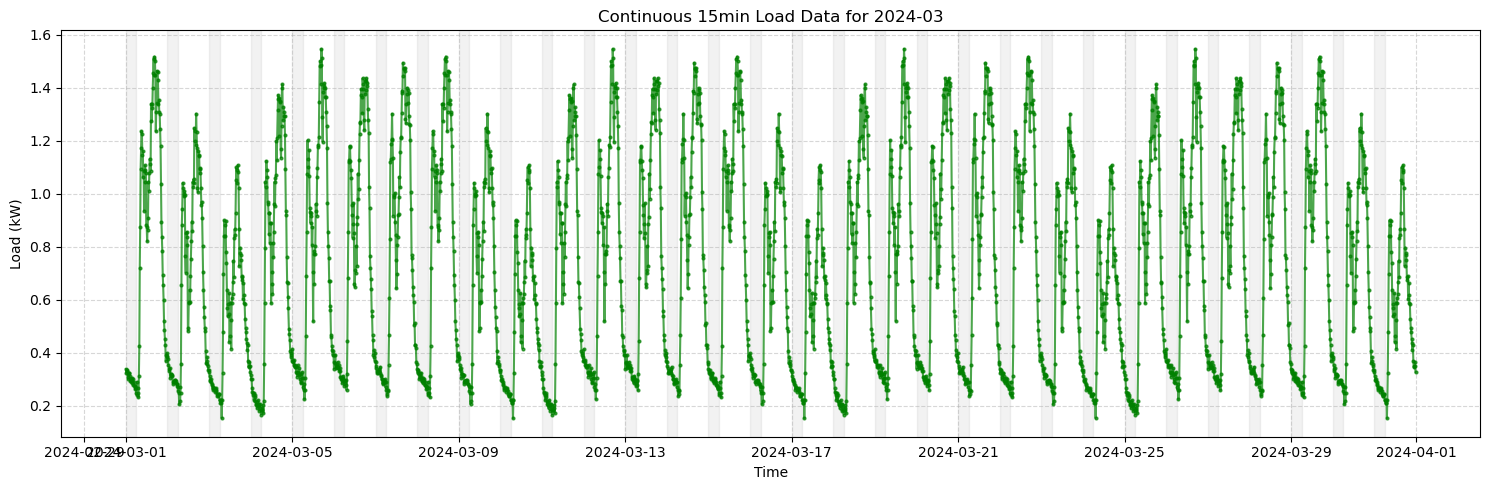

In [17]:
# First look at sample model graph
df_predict = pd.read_excel('Validation_predict.xlsx')

df_predict['date'] = pd.to_datetime(df_predict['date'])
df_predict.set_index('date', inplace=True)

selected_month = '2024-03'                             # Change this string to a different month if needed.
df_predict_month = df_predict.loc[selected_month]
df_predict_month = df_predict_month.sort_index()                       # Ensure the data for the selected month is sorted by date.

imputed = plot_monthly_load_data(df=df_predict_month, month_str=selected_month, power_columns=power_columns, freq='15min', color='green')

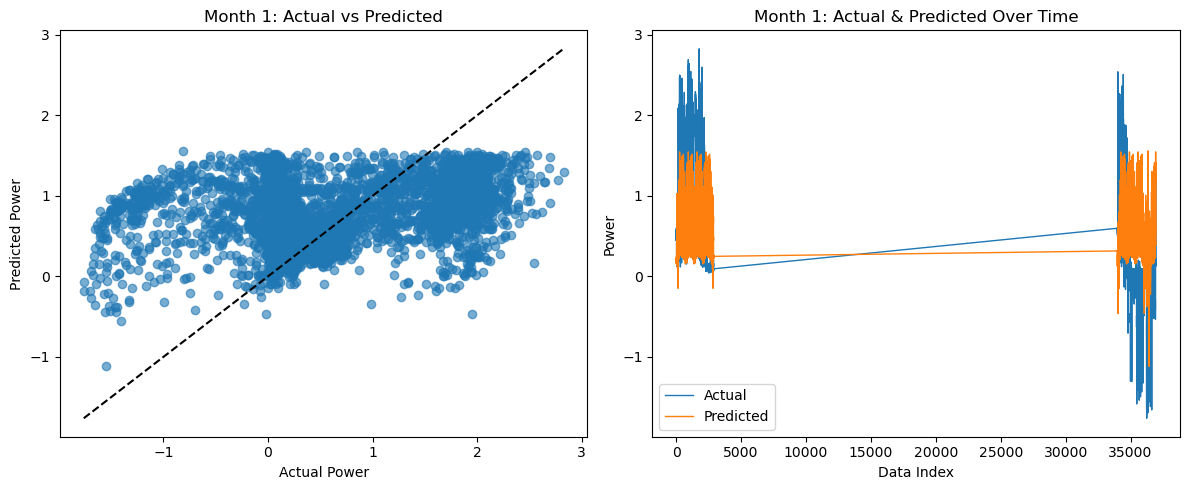

In [18]:
# Model Validation and Checking 
model_path    = 'power_model.xgb'
train_data    = 'preprocessed_data_2.xlsx'
val_data      = 'validation_data.xlsx'
check_data    = 'check_data_to_students.xlsx'
holiday_file  = 'China_Holiday_Calendar_2022_2024.xlsx'

model  = joblib.load(model_path)
selected_month = 1                            # Change to choose month to compare

df_tr = prepare_flat_with_date(train_data, holiday_file).dropna(subset=['value'])
features = ['time_slot','day_of_week','is_weekend','is_holiday']
df_tr['predicted'] = model.predict(df_tr[features])
df_tr['month'] = df_tr['date'].dt.month
df_first = df_tr[df_tr['month'] == selected_month]

# Scatter plot: Training vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(df_first['value'], df_first['predicted'], alpha=0.6)
min_v, max_v = df_first['value'].min(), df_first['value'].max()
axes[0].plot([min_v, max_v], [min_v, max_v], 'k--')
axes[0].set_xlabel('Actual Power')
axes[0].set_ylabel('Predicted Power')
axes[0].set_title(f'Month {selected_month}: Actual vs Predicted')

# Line plot: Time-series of the first month
axes[1].plot(df_first.index, df_first['value'], label='Actual', lw=1)
axes[1].plot(df_first.index, df_first['predicted'], label='Predicted', lw=1)
axes[1].set_xlabel('Data Index')
axes[1].set_ylabel('Power')
axes[1].set_title(f'Month {selected_month}: Actual & Predicted Over Time')
axes[1].legend()

plt.tight_layout()
plt.show()

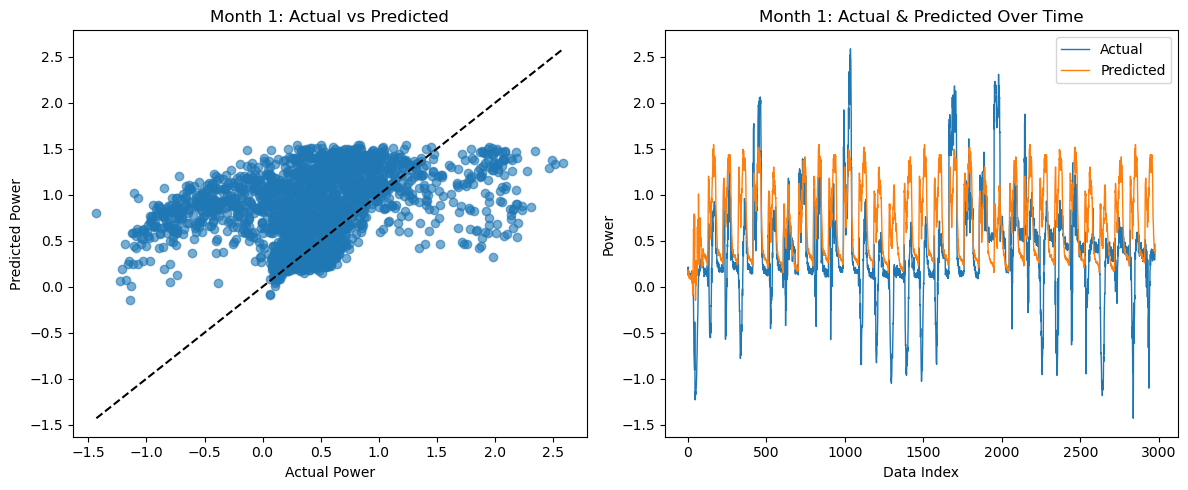

In [19]:
df_val = prepare_flat_with_date(val_data, holiday_file).dropna(subset=['value'])
features = ['time_slot','day_of_week','is_weekend','is_holiday']
df_val['predicted'] = model.predict(df_val[features])
df_val['month'] = df_val['date'].dt.month
df_second = df_val[df_val['month'] == selected_month]

# Scatter plot: Validation vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(df_second['value'], df_second['predicted'], alpha=0.6)
min_v, max_v = df_second['value'].min(), df_second['value'].max()
axes[0].plot([min_v, max_v], [min_v, max_v], 'k--')
axes[0].set_xlabel('Actual Power')
axes[0].set_ylabel('Predicted Power')
axes[0].set_title(f'Month {selected_month}: Actual vs Predicted')

# Line plot: Time-series of the second month
axes[1].plot(df_second.index, df_second['value'], label='Actual', lw=1)
axes[1].plot(df_second.index, df_second['predicted'], label='Predicted', lw=1)
axes[1].set_xlabel('Data Index')
axes[1].set_ylabel('Power')
axes[1].set_title(f'Month {selected_month}: Actual & Predicted Over Time')
axes[1].legend()

plt.tight_layout()
plt.show()

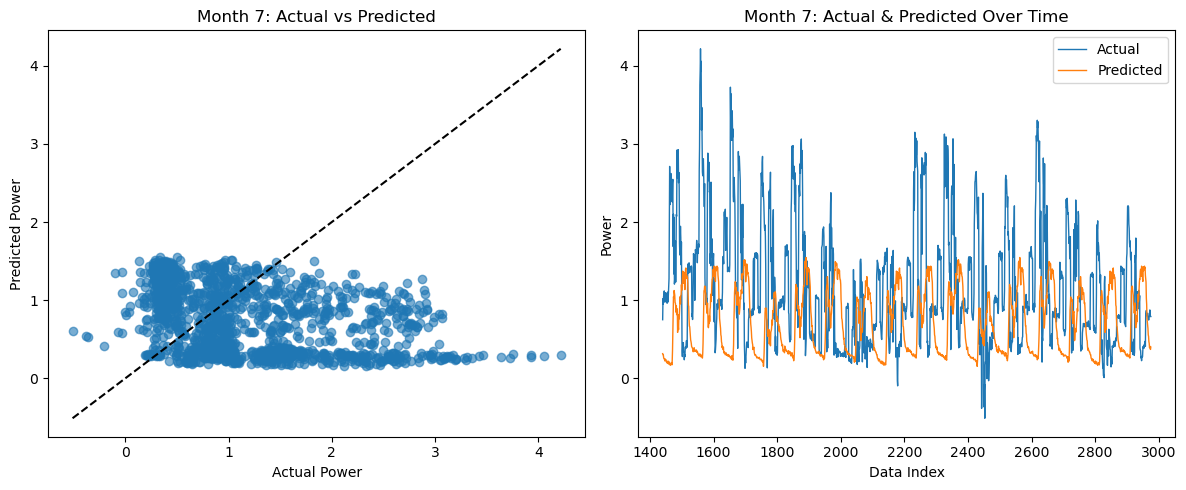

In [20]:
selected_month_2 = 7

df_check = prepare_flat_with_date(check_data, holiday_file).dropna(subset=['value'])
features = ['time_slot','day_of_week','is_weekend','is_holiday']
df_check['predicted'] = model.predict(df_check[features])
df_check['month'] = df_check['date'].dt.month
df_third = df_check[df_check['month'] == selected_month_2]

# Scatter plot: Checking vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(df_third['value'], df_third['predicted'], alpha=0.6)
min_v, max_v = df_third['value'].min(), df_third['value'].max()
axes[0].plot([min_v, max_v], [min_v, max_v], 'k--')
axes[0].set_xlabel('Actual Power')
axes[0].set_ylabel('Predicted Power')
axes[0].set_title(f'Month {selected_month_2}: Actual vs Predicted')

# Line plot: Time-series of the first month
axes[1].plot(df_third.index, df_third['value'], label='Actual', lw=1)
axes[1].plot(df_third.index, df_third['predicted'], label='Predicted', lw=1)
axes[1].set_xlabel('Data Index')
axes[1].set_ylabel('Power')
axes[1].set_title(f'Month {selected_month_2}: Actual & Predicted Over Time')
axes[1].legend()

plt.tight_layout()
plt.show()

In [21]:
# Performance Evaluation Helper Function
def compute_rmse(file_path, name):
    df = prepare_flat_with_date(file_path, holiday_file).dropna(subset=['value'])
    y_true = df['value'].values
    y_pred = model.predict(df[features])
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} RMSE: {rmse:.3f}")
    return rmse

In [22]:
# Performance Evaluation
train_file = 'preprocessed_data_2.xlsx'
holiday_file = 'China_Holiday_Calendar_2022_2024.xlsx'
validation_file = 'validation_data.xlsx'

# Train the model
model = train_power_model(train_file, holiday_file)

# Predict 2024 power values
predict_power(model, holiday_file, validation_file)

# Evaluate performance on 2024 validation set
evaluate_model_performance(model, holiday_file, validation_file)

Test RMSE: 0.6564
Power model saved to power_model.xgb
Power predictions saved to power_2024_predictions.xlsx
Validation Performance on validation_data.xlsx:
RMSE: 0.9156, MAE: 0.7150
SMAPE: 90.52%, MAPE (y>0.1): 77.70%
Bias (mean error): -0.1470, Bias-corrected RMSE: 0.9037

Error statistics by time slot:
              error           abs_pct_error          
               mean    median          mean    median
time_slot                                            
1         -0.517013 -0.262804      1.318908  0.746419
2         -0.516958 -0.248097      1.257084  0.752887
3         -0.519157 -0.286947      1.306896  0.761236
4         -0.526046 -0.271272      1.248852  0.763777
5         -0.533011 -0.279700      1.284827  0.770288
...             ...       ...           ...       ...
92        -0.531176 -0.287048      1.266358  0.721827
93        -0.529604 -0.290442      1.216983  0.733151
94        -0.518737 -0.255328      1.298624  0.743869
95        -0.550586 -0.329176      1.247785 

{'RMSE': 0.915599946176625,
 'MAE': 0.7149715289897519,
 'SMAPE': 90.51560227314434,
 'MAPE_nz': 77.70102420724587,
 'Bias': -0.14700069706071292,
 'Bias_RMSE': 0.9037223307646677,
 'slot_stats':               error           abs_pct_error          
                mean    median          mean    median
 time_slot                                            
 1         -0.517013 -0.262804      1.318908  0.746419
 2         -0.516958 -0.248097      1.257084  0.752887
 3         -0.519157 -0.286947      1.306896  0.761236
 4         -0.526046 -0.271272      1.248852  0.763777
 5         -0.533011 -0.279700      1.284827  0.770288
 ...             ...       ...           ...       ...
 92        -0.531176 -0.287048      1.266358  0.721827
 93        -0.529604 -0.290442      1.216983  0.733151
 94        -0.518737 -0.255328      1.298624  0.743869
 95        -0.550586 -0.329176      1.247785  0.748242
 96        -0.510855 -0.264437      1.251873  0.747395
 
 [96 rows x 4 columns]}

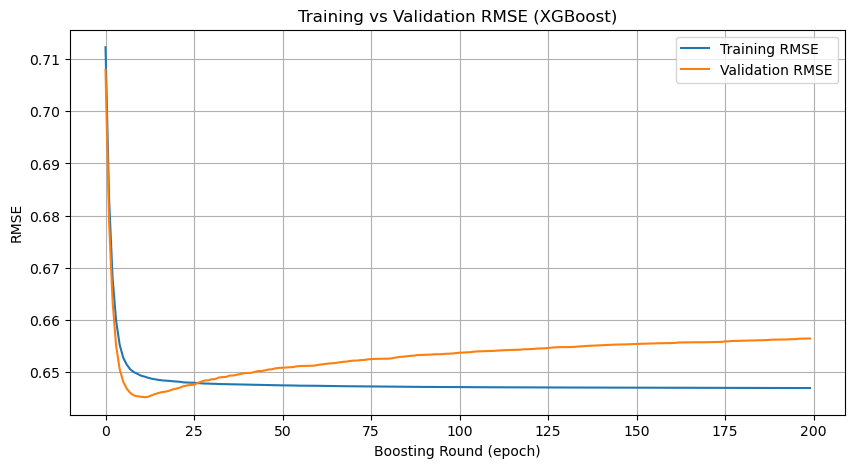

Training RMSE: 0.649
Validation RMSE: 0.916
Checking RMSE: 0.919


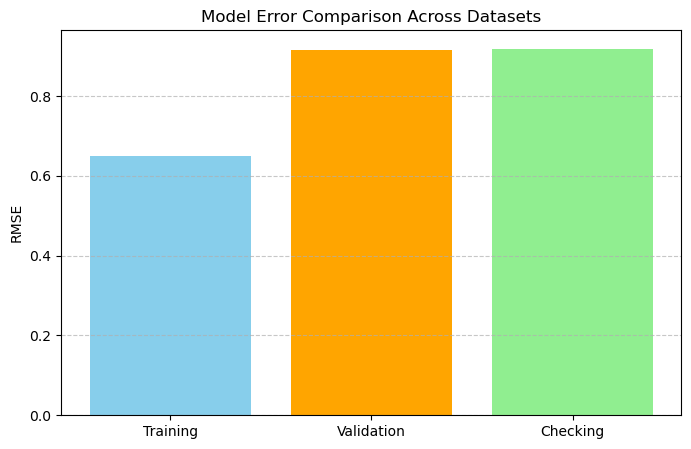

In [23]:
# Plot RMSE
epochs = range(len(results['validation_0']['rmse']))
plt.figure(figsize=(10, 5))
plt.plot(epochs, results['validation_0']['rmse'], label='Training RMSE')
plt.plot(epochs, results['validation_1']['rmse'], label='Validation RMSE')
plt.xlabel("Boosting Round (epoch)")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

# Compute RMSEs
rmse_train = compute_rmse(train_data, "Training")
rmse_val = compute_rmse(val_data, "Validation")
rmse_check = compute_rmse(check_data, "Checking")

# Plot
labels = ['Training', 'Validation', 'Checking']
rmse_values = [rmse_train, rmse_val, rmse_check]

plt.figure(figsize=(8, 5))
plt.bar(labels, rmse_values, color=['skyblue', 'orange', 'lightgreen'])
plt.ylabel('RMSE')
plt.title('Model Error Comparison Across Datasets')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()